In [7]:
!apt update
!apt-get install libglu1 -y
!pip install kornia_moons --upgrade
!pip install opencv-python
!pip install opencv-contrib-python
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install pydegensac

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
53 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libglu1-mesa' instead of 'libglu1'
libglu1-mesa is already the newest version (9.0.1-1build1).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Enabling notebook exte

In [3]:
!pip install git+https://github.com/kornia/kornia

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-3gv0kc1e
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-3gv0kc1e
  Resolved https://github.com/kornia/kornia to commit 3bff4ee773a77777aac2ce6f15dacd83db301670
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [4]:
import pydegensac
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *
from ipywidgets import FloatProgress
import time

def resize(scale,img):
    scale_percent = scale  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized

def load_torch_image(fname,s, rot=0):
    img= cv2.imread(fname)
    if rot==90:
        img=img
    if rot==90:
        img=cv2.rotate(img,cv2.cv2.ROTATE_90_CLOCKWISE)
    elif rot==180:
        img=cv2.rotate(img,cv2.cv2.ROTATE_180)
    elif rot==270 or rot==-90:
        img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
    img=resize(s,img)
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img

In [49]:
start=time.time()
fname1 = '../../Data/3D_sim_tests/newLS_drone_3Drot1_180_highQ.png'#"../../Data/Template_imgs/Sub_Scale_Launch_full.jpg"
fname2 = '../../Data/NewLSTemplates/newLS_sat_4-4_highQ.png'#'rectified.jpg'
acc=[0,0,0,0]
true_inliers=[]
f_mkpoints=[]
for t in range(4):

    img1 = load_torch_image(fname1,30,0+90*t)
    img2 = load_torch_image(fname2,30)


    matcher = KF.LoFTR(pretrained='outdoor')

    input_dict = {"image0": K.color.rgb_to_grayscale(img1), # LofTR works on grayscale images only 
                  "image1": K.color.rgb_to_grayscale(img2)}

    with torch.no_grad():
        correspondences = matcher(input_dict)
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    f_mkpoints.append([mkpts0, mkpts1])
    H1, inliers1 = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.9999, 100000)
    inliers1 = inliers1 > 0
    H2, inliers2 = pydegensac.findFundamentalMatrix(mkpts0, mkpts1, 0.5)
    inliers_i= []
    for i,k in enumerate(inliers1):
        if(k[0]==True and inliers2[i]==True):
            inliers_i.append(True)
            acc[t]+=1
        else:
            inliers_i.append(False)
    true_inliers.append(inliers_i)
    if acc[t]<10:
        acc[t]=0
        continue
    elif acc[t]>30:
        break

f=acc.index(max(acc))
n_img1 = load_torch_image(fname1,30,0+90*f)
inliers=np.array(true_inliers[f])
n_mkpts0=f_mkpoints[f][0]
n_mkpts1=f_mkpoints[f][1]
end=time.time()
print(f'Time after time: {end-start}')

Time after time: 43.11687612533569


In [50]:
print(f)
print(len(mkpts1))
print(len(inliers))

2
218
218


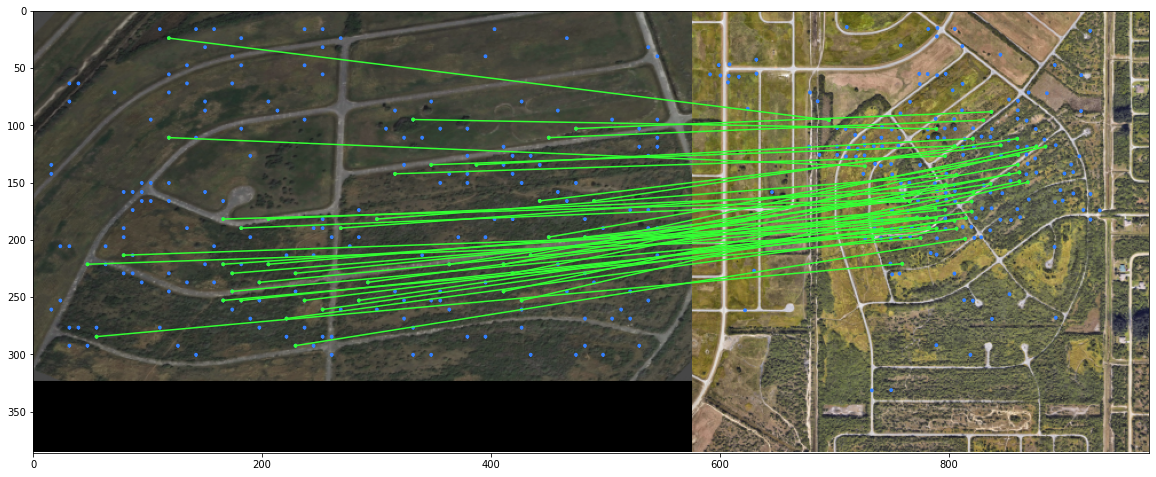

In [51]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(n_mkpts0).view(1,-1, 2),
                                torch.ones(n_mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(n_mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(n_mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(n_mkpts1.shape[0]).view(1,-1, 1)),
    torch.arange(n_mkpts0.shape[0]).view(-1,1).repeat(1,2),
    K.tensor_to_image(n_img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': (0.2, 0.5, 1), 'vertical': False})